In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pingouin as pg
from scikit_posthocs import posthoc_nemenyi_friedman, posthoc_conover_friedman, sign_plot, sign_plot
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import os
import re, sys, glob
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import auc


# Report result on Supplemental S2 Fig 2:  Feature perturbation curve of cumulative feature removal experiment on the glioma task. 


In [2]:
gradient_method = ["Gradient", "InputXGradient", "SmoothGrad",
                         "Deconvolution","GuidedBackProp", "GuidedGradCAM",
                         "IntegratedGradients", "DeepLift", "GradientShap"
                         ]
perturbation_method = ["Occlusion", "FeatureAblation", "KernelShap", "ShapleyValueSampling",
                           "FeaturePermutation", "Lime"]
activation_method = ["GradCAM"]
def plot_acc_drop(modified_input_save_root, fold, fold_perfm=None, accdrop_keyword = 'acc_drop', seed_or_fold_keyword = 'fold', gethmkw = 'get_hm_fold_1', performance_label = 'Accuracy'):
    '''
    plot the acc drop line for each xai method
    :param drop_dict:
    :param auc_list:
    :return:
    '''
    if seed_or_fold_keyword == 'fold':
        performance_label = 'Accuracy'
        
    sns.set_style("whitegrid")
    fold_result = []

    auc_record = dict()
    # get all subdir
    fold_acc_drop_path = Path(os.path.join(modified_input_save_root, "{}_{}".format(seed_or_fold_keyword, fold), gethmkw.format(fold), accdrop_keyword))
    method_list = [f.name.split('_')[0] for f in fold_acc_drop_path.rglob('*_acc_drop_record.csv')]
    print('method_list', len(method_list))
#     print('fold_acc_drop_path', fold_acc_drop_path)
    drop_dict = dict()
    df_lst = []
    # calculate roc
    auc_diff = dict()
    for m in method_list:
        csv_filename = fold_acc_drop_path /'{}_acc_drop_record.csv'.format(m)
        csv = pd.read_csv(csv_filename, index_col=0)
        if fold_perfm is not None:
            csv.iloc[0,:] = fold_perfm[fold]

        # replace the first row to adjust the baseline accuracy, using fold_perfm
        quantile_step = csv.index

        xai_acc_drop = csv[m]
        drop_dict[m] = xai_acc_drop
#         print(drop_dict)

        # calculate baseline acc drop
        bl_col = [col for col in csv if col.startswith('baseline_')]
        bl_acc_drop = csv[bl_col].mean(axis=1).to_dict()
        bl_acc_drop_std = csv[bl_col].std(axis=1).to_dict()
        drop_dict['{}_baseline'.format(m)] = list(bl_acc_drop.values())
        drop_dict['{}_blstd'.format(m)] = list(bl_acc_drop_std.values())
        # auc
        area = auc(quantile_step, xai_acc_drop)
        auc_record[m] = area
        bl_auc = auc(quantile_step, list(bl_acc_drop.values()))
        auc_record['{}_baseline'.format(m)] = bl_auc
        auc_diff[m] = bl_auc - area

        # modify the col name to be combined
        csv.reset_index(level=0, inplace=True)
        df = csv.rename(columns={'index': 'quantile', m: 'baseline_0'})
        method_result_dict = {'fold': fold, 'method': m, 'AUC': area, 'baseline AUC': bl_auc, 'diffAUC': bl_auc-area}
        fold_result.append(method_result_dict)

#         df['xai_label'] = '{}. \nAUC = {:.2f}. \nIts baseline AUC = {:.2f}. \nAUC difference: {:.2f}'.format(m, area, bl_auc, bl_auc-area)
        df['xai_label'] = '{}.\nΔAUPC = {:.2f} - {:.2f} = {:.2f}'.format(m,  bl_auc, area, bl_auc-area)
        #         print(df)

        df_long = pd.wide_to_long(df, ['baseline'], i='quantile', j='trialID',
                                  sep='_')  # df.melt('quantile',  var_name='cols',  value_name='vals')
        df_long = df_long.rename(columns={'baseline': 'accuracy'})
        df_long.reset_index(inplace=True)

        df_long['mORb'] = 'baseline'
        df_long.loc[df_long['trialID'] == 0, 'mORb'] = 'xaiMethod'
        #         print(df_long)

        df_lst.append(df_long)

    # combine all csvs
    aggregate_df = pd.concat(df_lst)
    # sort the method according to auc diff
    methods_sorted_by_auc = dict(sorted(auc_diff.items(), reverse=True, key=lambda item: item[1]))
    # convert the order to xai title name
    sorted_xai_mapping = []
    for m in methods_sorted_by_auc:
        for title in aggregate_df['xai_label'].unique():
            if m == title.split('.')[0]:
                sorted_xai_mapping.append(title)

    # plot
    with sns.plotting_context("notebook", font_scale=1.35):
        g1 = sns.relplot(
            data=aggregate_df, x='quantile', y='accuracy', style='mORb',   dashes={"xaiMethod": [5, 0], "baseline":[1, 5]}, 
            markers={"xaiMethod": 'o', "baseline":'.'},
            kind='line', col='xai_label', col_wrap=4, col_order = sorted_xai_mapping
        )
        
        g1.set_titles("{col_name}")
        g1.set(xlim=(0, 1), ylim=(0, 1), xticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], yticks=[0, 0.2,0.4, 0.6,0.8, 1])
        g1.set_axis_labels('Feature removal quantile', "{}".format(performance_label))
        g1.tight_layout(w_pad=1)

        g1._legend.remove()
        # save figure
        dateTimeObj = datetime.now()
        time_stamp = dateTimeObj.strftime("%Y%m%d_%H%M")
        fig_name = '{}-{}-{}.pdf'.format(accdrop_keyword, seed_or_fold_keyword, fold)
#         g1.savefig(Path('../reporting')/ fig_name, bbox_inches="tight")
    return fold_result, aggregate_df, g1



/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


method_list 16


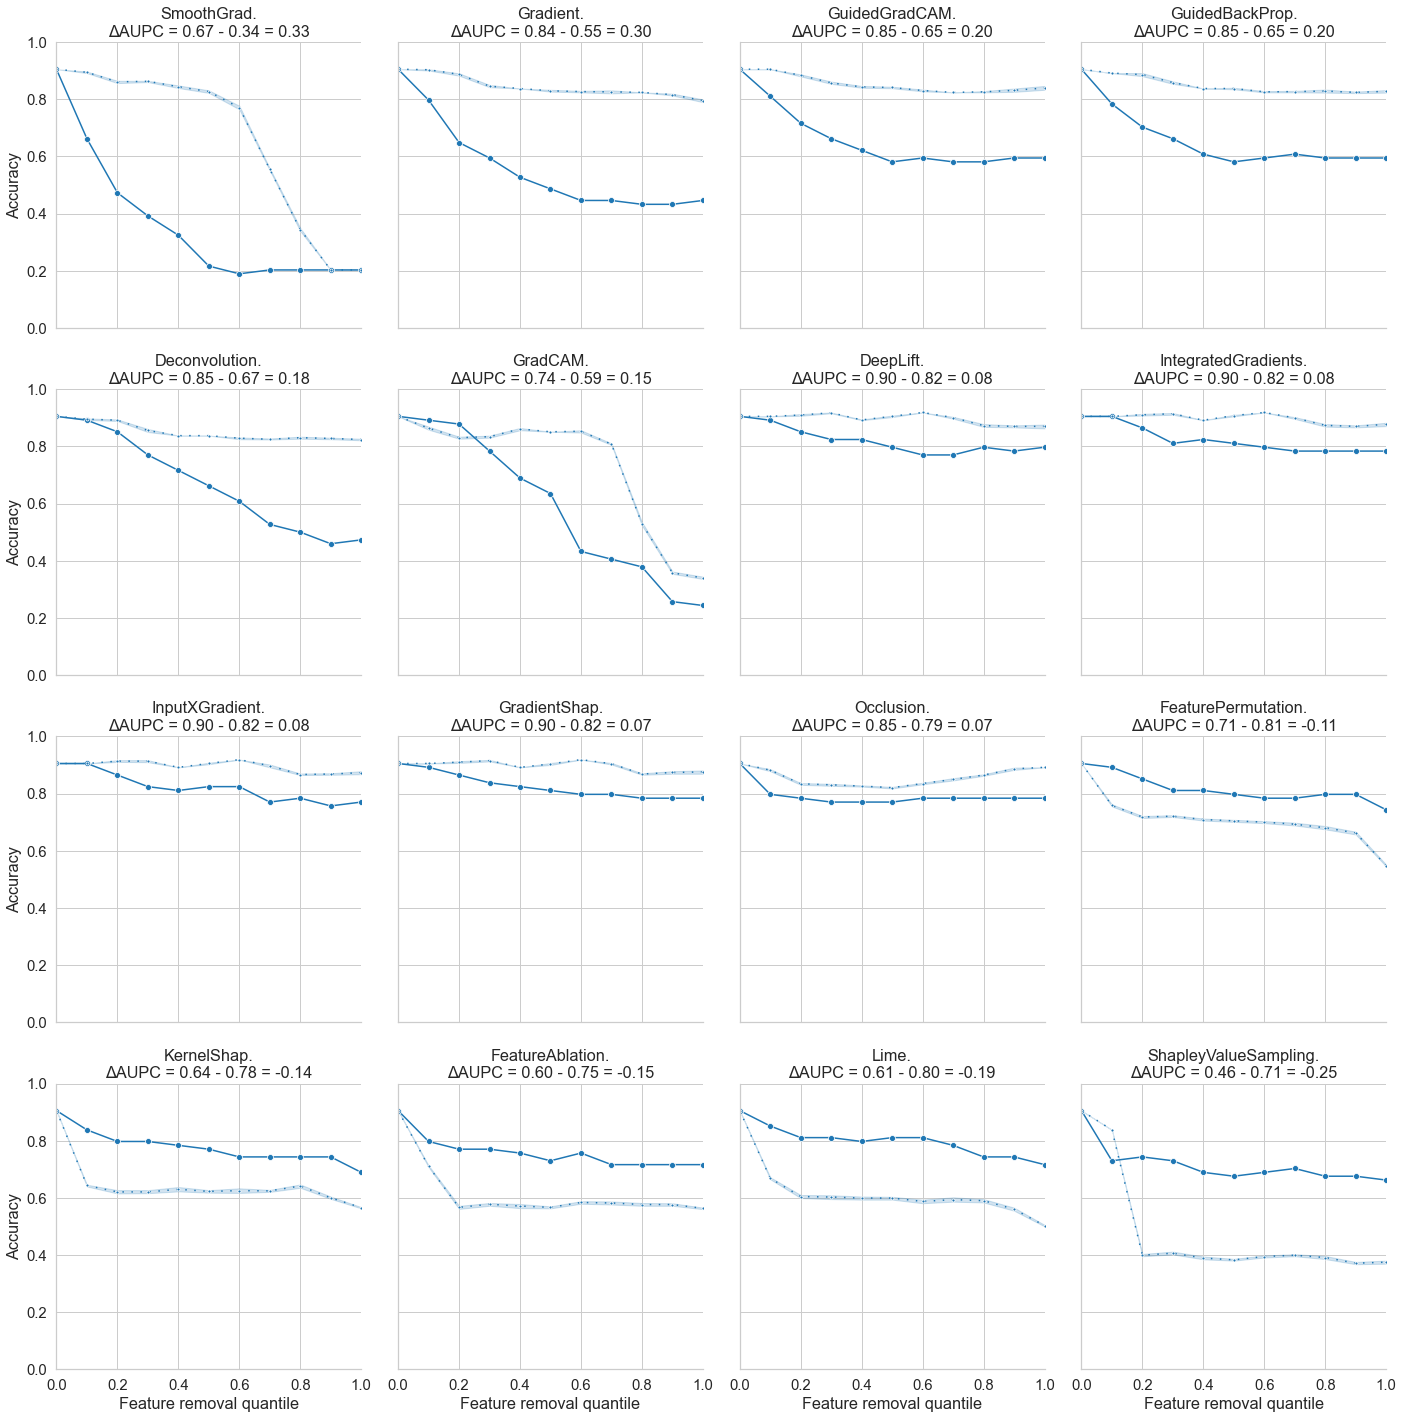

In [4]:
file_dir = '../computational_data/cumulative_feature_removal'
fold1_result, aggregate_df, g1= plot_acc_drop(file_dir, fold = 1,fold_perfm= {1: 67/74})
